## Analysis of Long-Horizon Agents


In [1]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap


plt.rcParams.update({
    "font.family": "Inter",
    "font.size": 12,    # base
    "axes.labelsize": 12,   # x/y labels
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.facecolor": "white",
    "axes.spines.top": False,
    "axes.spines.right": False,
})

def darken(color, factor=0.8):
    """factor <1 darkens, >1 brightens."""
    rgb = np.array(mcolors.to_rgb(color))
    darker = np.clip(rgb * factor, 0, 1)
    return mcolors.to_hex(darker)

In [2]:
BASE_DIR = Path(os.getcwd())

csv_path = BASE_DIR / 'params' / 'all_a_pyirt.csv'
all_runs_path = BASE_DIR / 'data' / 'all_runs.jsonl'
mlebench_results_path = BASE_DIR / 'data' / 'mlebench_normalized_results.jsonl'
gdpval_results_path = BASE_DIR / 'data' / 'gdpval_normalized_results.jsonl'
swebench_results_path = BASE_DIR / 'data' / 'swebench_normalized_results.jsonl'
abilities_path = BASE_DIR / 'params' / 'all_a_pyirt_abilities.csv'

In [3]:
def load_jsonl_records(path: Path):
    records = []
    with path.open('r') as f:
        for line in f:
            records.append(json.loads(line))
    return records

### Task Length vs Task Difficulty


In [10]:
metr_records = load_jsonl_records(all_runs_path)
metr_task_sources = {}
for record in metr_records:
    task_id = record.get('task_id')
    task_source = record.get('task_source')
    if task_id and task_source and task_id not in metr_task_sources:
        metr_task_sources[task_id] = task_source.lower().replace('-', '')

mlebench_task_ids = {record['task_id'] for record in load_jsonl_records(mlebench_results_path)}
gdpval_task_ids = {record['task_id'] for record in load_jsonl_records(gdpval_results_path)}
swebench_task_ids = {record['task_id'] for record in load_jsonl_records(swebench_results_path)}

print(f"# of tasks in METR: {len(metr_task_sources)}")
print(f"# of tasks in MLEBench: {len(mlebench_task_ids)}")
print(f"# of tasks in GDPVal: {len(gdpval_task_ids)}")
print(f"# of tasks in SweBench: {len(swebench_task_ids)}")

# of tasks in METR: 170
# of tasks in MLEBench: 38
# of tasks in GDPVal: 220
# of tasks in SweBench: 500


In [11]:
df = pd.read_csv(csv_path)
task_id_column = df.columns[0]
if task_id_column != 'task_id':
    df = df.rename(columns={task_id_column: 'task_id'})

df['task_id'] = df['task_id'].astype(str)
df['base_task'] = df['task_id'].str.split('::').str[0]
df['metric'] = df['task_id'].str.split('::').str[1]
for numeric_column in ['a', 'b', 'human_minutes']:
    df[numeric_column] = pd.to_numeric(df[numeric_column], errors='coerce')

df['task_source'] = df['task_id'].map(metr_task_sources)
df.loc[df['task_id'].isin(swebench_task_ids), 'task_source'] = 'swebench'
df.loc[df['task_id'].isin(gdpval_task_ids), 'task_source'] = 'gdpval'
df.loc[df['base_task'].isin(mlebench_task_ids), 'task_source'] = 'mlebench'

df['task_source'] = df['task_source'].fillna('Unknown')
print(f"# of tasks by source:\n{df['task_source'].value_counts().to_string()}")


# of tasks by source:
task_source
swebench    500
gdpval      220
mlebench    114
hcast        97
swaa         66
rebench       7


In [12]:
METR_SOURCES = {'hcast', 'rebench', 'swaa'}
use_metr_only = True  # toggle this to False to fit using every available task
if use_metr_only:
    filtered_sources = METR_SOURCES
    source_label = 'METR-only'
else:
    filtered_sources = None
    source_label = 'all sources'

plot_df = df.dropna(subset=['b', 'human_minutes']).copy()
plot_df = plot_df[np.isfinite(plot_df['b']) & np.isfinite(plot_df['human_minutes'])]
plot_df = plot_df[plot_df['human_minutes'] > 0]
if filtered_sources is not None:
    plot_df = plot_df[plot_df['task_source'].isin(filtered_sources)]
if plot_df.empty:
    raise ValueError('No rows with both b and human_minutes values for linear fit')

sources_used = ', '.join(sorted(plot_df['task_source'].dropna().unique())) or 'none'
print(f"Fitting regression on {len(plot_df)} rows ({source_label}; sources: {sources_used})")

x_b = plot_df['b'].to_numpy()
y_log_minutes = np.log(plot_df['human_minutes'].to_numpy())

Fitting regression on 170 rows (METR-only; sources: hcast, rebench, swaa)


In [13]:
reg = stats.linregress(x_b, y_log_minutes)
r_squared = reg.rvalue ** 2

print("-" * 50)
print("Linear Regression: b vs. log(minutes) coefficients")
print("-" * 50)
print(f"> slope: {reg.slope:.6f}")
print(f"> intercept: {reg.intercept:.6f}")
print(f"> r-value: {reg.rvalue:.6f}")
print(f"> R^2: {r_squared:.6f}")
print(f"> p-value: {reg.pvalue:.6g}")
print(f"> std err: {reg.stderr:.6f}")

x_line = np.linspace(x_b.min(), x_b.max(), 500)
y_line = reg.intercept + reg.slope * x_line

def predict_minutes_from_b(b_values):
    return np.exp(reg.intercept + reg.slope * b_values)

--------------------------------------------------
Linear Regression: b vs. log(minutes) coefficients
--------------------------------------------------
> slope: 0.857533
> intercept: 2.699453
> r-value: 0.902875
> R^2: 0.815183
> p-value: 1.73253e-63
> std err: 0.031502


----------------------------------------------------------------------------------------------------
Human Time-to-Complete (log scale) vs Task difficulty (b)
----------------------------------------------------------------------------------------------------


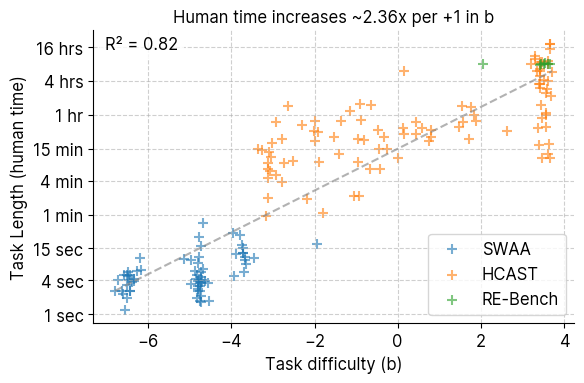

In [14]:
color_map = [
    ('swaa', 'SWAA', '#1f77b4'),
    ('hcast', 'HCAST', '#ff7f0e'),
    ('rebench', 'RE-Bench', '#2ca02c'),
]

print("-" * 100)
print("Human Time-to-Complete (log scale) vs Task difficulty (b)")
print("-" * 100)

fig, ax = plt.subplots(figsize=(6, 4))

for task_source, task_source_label, color in color_map:
    subset = plot_df[plot_df['task_source'] == task_source]
    ax.scatter(subset['b'], subset['human_minutes'], label=task_source_label, color=color, alpha=0.6, marker='+', s=50, linewidth=1.5)

ax.set_yscale('log')
xticks = [
    1/60, 4/60, 15/60, 1, 4, 15, 60, 4*60, 16*60, 64*60,
]
xtick_labels = [
    "1 sec", "4 sec", "15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs", "16 hrs", "64 hrs"
]
ax.set_yticks(xticks)
ax.set_yticklabels(xtick_labels, ha="right")


ax.plot(x_line, np.exp(y_line), color="#7f7f7f", linestyle='--', alpha=0.6, linewidth=1.5)
ax.set_xlabel("Task difficulty (b)")
ax.set_ylabel("Task Length (human time)")

legend = ax.legend(loc="lower right", frameon=True, fancybox=True)
ax.grid(True, which="major", linestyle="--", alpha=0.6)
ax.minorticks_off()

mult_factor = np.exp(reg.slope)
percent_increase = (mult_factor - 1) * 100

ax.text(
    0.025, 0.98, 
    f"R\u00b2 = {r_squared:.2f}",
    transform=ax.transAxes, 
    ha="left", va="top",
    fontsize=12,
    verticalalignment='top', 
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='white')
)
plt.title(f"Human time increases ~{mult_factor:.2f}x per +1 in b", fontsize=12)

fig.tight_layout()
fig.savefig(BASE_DIR / "plots" / f'task_difficulty_vs_human_time_{source_label.replace(" ", "_")}.pdf', dpi=300)
plt.show()

### Task Length Estimation


In [15]:
mlebench_predictions = df[(df['base_task'].isin(mlebench_task_ids)) & (df['task_source'] == 'mlebench') & (df['b'].notna())]
mlebench_predictions = mlebench_predictions.copy().reset_index(drop=True)
mlebench_predictions['predicted_minutes'] = predict_minutes_from_b(mlebench_predictions['b'])
mlebench_predictions = mlebench_predictions.sort_values(['base_task', 'metric'])
print("-" * 100)
print(f"Predicted human minutes for {len(mlebench_predictions)} MLE Bench task-metrics.")
print("-" * 100)
preview_cols = ['task_id', 'base_task', 'metric', 'b', 'predicted_minutes']
display(mlebench_predictions[preview_cols].head(5))


gdpval_predictions = df[(df['base_task'].isin(gdpval_task_ids)) & (df['task_source'] == 'gdpval') & (df['b'].notna())]
gdpval_predictions = gdpval_predictions.copy().reset_index(drop=True)
gdpval_predictions['predicted_minutes'] = predict_minutes_from_b(gdpval_predictions['b'])
gdpval_predictions = gdpval_predictions.sort_values('task_id')
print("-" * 100)
print(f"Predicted human minutes for {len(gdpval_predictions)} GDPval tasks.")
print("-" * 100)
preview_cols = ['task_id', 'b', 'predicted_minutes']
display(gdpval_predictions[preview_cols].head(5))


swebench_predictions = df[(df['base_task'].isin(swebench_task_ids)) & (df['task_source'] == 'swebench') & (df['b'].notna())]
swebench_predictions = swebench_predictions.copy().reset_index(drop=True)
swebench_predictions['predicted_minutes'] = predict_minutes_from_b(swebench_predictions['b'])
swebench_predictions = swebench_predictions.sort_values('task_id')
print("-" * 100)
print(f"Predicted human minutes for {len(swebench_predictions)} SWE-bench tasks.")
print("-" * 100)
preview_cols = ['task_id', 'human_minutes', 'b', 'predicted_minutes']
display(swebench_predictions[preview_cols].head(5))


----------------------------------------------------------------------------------------------------
Predicted human minutes for 114 MLE Bench task-metrics.
----------------------------------------------------------------------------------------------------


,task_id,base_task,metric,b,predicted_minutes
60,AI4Code::above_median,AI4Code,above_median,4.317305,602.860851
61,AI4Code::any_medal,AI4Code,any_medal,4.210889,550.282261
62,AI4Code::valid_submission,AI4Code,valid_submission,-3.287810,0.886962
0,aerial-cactus-identification::above_median,aerial-cactus-identification,above_median,4.415765,655.972795
1,aerial-cactus-identification::any_medal,aerial-cactus-identification,any_medal,4.860632,960.648098


----------------------------------------------------------------------------------------------------
Predicted human minutes for 220 GDPval tasks.
----------------------------------------------------------------------------------------------------


,task_id,b,predicted_minutes
0,0112fc9b-c3b2-4084-8993-5a4abb1f54f1,-3.212518,0.946118
1,01d7e53e-0513-4109-a242-8ccaf442cd21,-0.300184,11.496417
2,02314fc6-a24e-42f4-a8cd-362cae0f0ec1,-2.034356,2.598475
3,02aa1805-c658-4069-8a6a-02dec146063a,0.591576,24.698674
4,0353ee0c-18b5-4ad3-88e8-e001d223e1d7,1.451648,51.639651


----------------------------------------------------------------------------------------------------
Predicted human minutes for 500 SWE-bench tasks.
----------------------------------------------------------------------------------------------------


,task_id,human_minutes,b,predicted_minutes
0,astropy__astropy-12907,30.0,-0.751985,7.803723
1,astropy__astropy-13033,30.0,5.261611,1354.869296
2,astropy__astropy-13236,30.0,4.705755,841.171697
3,astropy__astropy-13398,120.0,5.174008,1256.817610
4,astropy__astropy-13453,30.0,0.050804,15.533822


----------------------------------------------------------------------------------------------------
Human Time-to-Complete Estimates from IRT Task Difficulty
----------------------------------------------------------------------------------------------------


/var/folders/rs/m2mywrv52bl5mvyt484882d80000gn/T/ipykernel_7799/2893690241.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_counts = swebench_predictions.groupby(['time_bucket', 'correct_bucket']).size().unstack(fill_value=0)


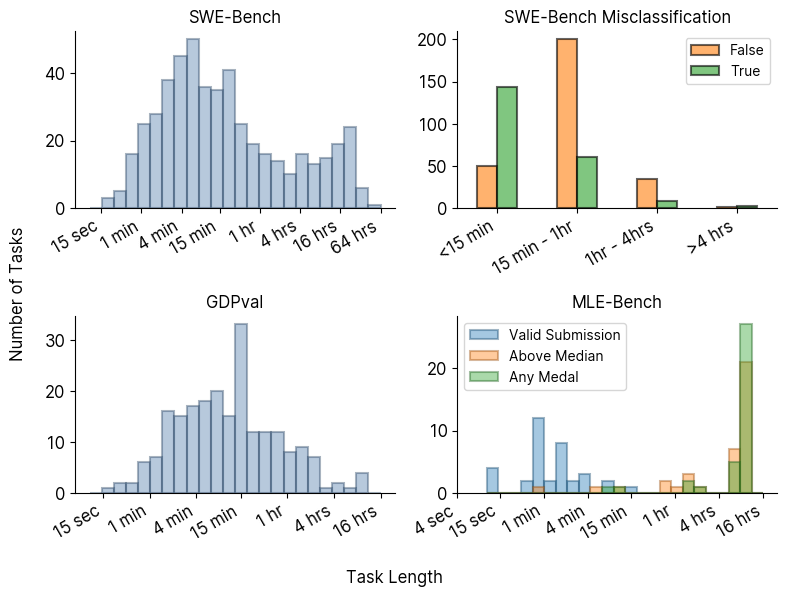

In [24]:
xticks = [
    1/60, 4/60, 15/60, 1, 4, 15, 60, 4*60, 16*60, 64*60,
]
xtick_labels = [
    "1 sec", "4 sec", "15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs", "16 hrs", "64 hrs"
]


print("-" * 100)
print("Human Time-to-Complete Estimates from IRT Task Difficulty")
print("-" * 100)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
axes = axes.flatten()

# -----------------------------------------------
# subplot 1: SWE human_minutes histogram (1, 1)
# -----------------------------------------------
ax = axes[0]

minutes = swebench_predictions["predicted_minutes"].to_numpy()
minutes = minutes[np.isfinite(minutes) & (minutes > 0)]

bins = np.geomspace(10/60, 64*60, 25)
ax.hist(minutes, bins=bins, color="#4c78a8", alpha=0.4, edgecolor="#26415f", linewidth=1.5)

ax.set_xscale('log')
ax.set_xticks(xticks[2:])
ax.set_xticklabels(xtick_labels[2:], ha="right", rotation=30)

# ax.set_xlabel("Task Length")
# ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("SWE-Bench", fontsize=12)


# -----------------------------------------------
# subplot 2: SWE predicted_minutes misclassification (1, 2)
# -----------------------------------------------
ax = axes[1]
bins = [0, 15, 60, 240, np.inf]
labels = ['<15 min', '15 min - 1hr', '1hr - 4hrs', '>4 hrs']

# keep interval information
intervals = pd.cut(
    swebench_predictions['human_minutes'],
    bins=bins,
    include_lowest=True
)

# readable bucket label
swebench_predictions['time_bucket'] = intervals.map(lambda iv: labels[bins.index(iv.right) - 1])

# correctness check based on interval bounds
is_correct = []
for i, row in swebench_predictions.iterrows():
    is_correct.append(row['predicted_minutes'] >= intervals.iloc[i].left and row['predicted_minutes'] <= intervals.iloc[i].right)
swebench_predictions['correct_bucket'] = is_correct

# plot the bar chart with correct and incorrect counts across buckets
bucket_counts = swebench_predictions.groupby(['time_bucket', 'correct_bucket']).size().unstack(fill_value=0)
bucket_counts = bucket_counts.reindex(labels)  # ensure consistent order

bucket_counts.plot(
    kind='bar',
    stacked=False,
    color=['#ff7f0e', '#2ca02c'],
    edgecolor='black',
    alpha=0.6,
    linewidth=1.5,
    ax=ax
)

ax.set_xlabel(None)
# ax.set_xlabel("Task Length")
# ax.set_ylabel("Number of Tasks")
ax.set_xticklabels(labels, ha="right", rotation=30)
ax.minorticks_off()

ax.set_title("SWE-Bench Misclassification", fontsize=12)
ax.legend(loc="best", frameon=True, fancybox=True, fontsize=10)

# -----------------------------------------------
# subplot 3: MLE bench human_minutes histogram (2, 1)
# -----------------------------------------------
ax = axes[3]

mle_metric_specs = [
    ('valid_submission', '#1f77b4'),
    ('above_median', '#ff7f0e'),
    ('any_medal', '#2ca02c'),
]

for spec_name, color in mle_metric_specs:
    mlebench_predictions_subset = mlebench_predictions[mlebench_predictions['metric'] == spec_name]
    minutes = mlebench_predictions_subset["predicted_minutes"]
    minutes = minutes[np.isfinite(minutes) & (minutes > 0)].to_numpy()

    bins = np.geomspace(10/60, 16*60, 25)
    ax.hist(
        minutes, bins=bins, color=color, alpha=0.4, 
        edgecolor=darken(color, 0.6), linewidth=1.5, label=spec_name.replace('_', ' ').title()
    )

ax.set_xscale('log')
ax.set_xticks(xticks[1:-1])
ax.set_xticklabels(xtick_labels[1:-1], ha="right", rotation=30)

# ax.set_xlabel("Task Length")
# ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("MLE-Bench", fontsize=12)
ax.legend(loc="best", frameon=True, fancybox=True, fontsize=10)


# -----------------------------------------------
# subplot 4: GDPval human_minutes histogram (2, 2)
# -----------------------------------------------
ax = axes[2]

minutes = gdpval_predictions["predicted_minutes"].to_numpy()
minutes = minutes[np.isfinite(minutes) & (minutes > 0)]

bins = np.geomspace(10/60, 16*60, 25)
ax.hist(minutes, bins=bins, color="#4c78a8", alpha=0.4, edgecolor="#26415f", linewidth=1.5)

ax.set_xscale('log')
ax.set_xticks(xticks[2:-1])
ax.set_xticklabels(xtick_labels[2:-1], ha="right", rotation=30)

# ax.set_xlabel("Task Length")
# ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("GDPval", fontsize=12)

fig.supxlabel("Task Length", fontsize=12)
fig.supylabel("Number of Tasks", fontsize=12)

fig.tight_layout(pad=1)
plt.show()

----------------------------------------------------------------------------------------------------
Human Time-to-Complete Estimates from IRT Task Difficulty
----------------------------------------------------------------------------------------------------


/var/folders/rs/m2mywrv52bl5mvyt484882d80000gn/T/ipykernel_7799/2268343060.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, ha="right", rotation=30)


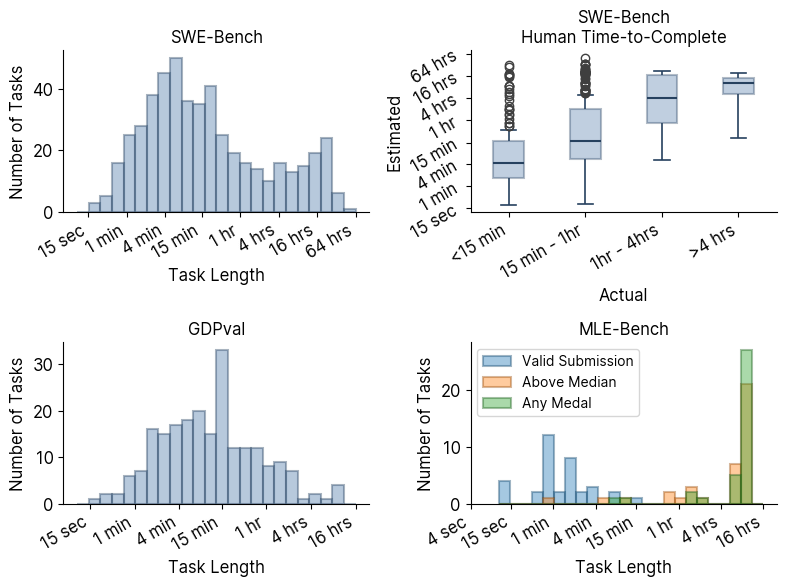

In [25]:
xticks = [
    1/60, 4/60, 15/60, 1, 4, 15, 60, 4*60, 16*60, 64*60,
]
xtick_labels = [
    "1 sec", "4 sec", "15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs", "16 hrs", "64 hrs"
]

print("-" * 100)
print("Human Time-to-Complete Estimates from IRT Task Difficulty")
print("-" * 100)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
axes = axes.flatten()

# -----------------------------------------------
# subplot 1: SWE human_minutes histogram (1, 1)
# -----------------------------------------------
ax = axes[0]

minutes = swebench_predictions["predicted_minutes"].to_numpy()
minutes = minutes[np.isfinite(minutes) & (minutes > 0)]

bins = np.geomspace(10/60, 64*60, 25)
ax.hist(minutes, bins=bins, color="#4c78a8", alpha=0.4, edgecolor="#26415f", linewidth=1.5)

ax.set_xscale('log')
ax.set_xticks(xticks[2:])
ax.set_xticklabels(xtick_labels[2:], ha="right", rotation=30)

ax.set_xlabel("Task Length")
ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("SWE-Bench", fontsize=12)


# -----------------------------------------------
# subplot 2: SWE predicted_minutes misclassification (1, 2)
# -----------------------------------------------
ax = axes[1]
bins = [0, 15, 60, 240, np.inf]
labels = ['<15 min', '15 min - 1hr', '1hr - 4hrs', '>4 hrs']

# keep interval information
intervals = pd.cut(
    swebench_predictions['human_minutes'],
    bins=bins,
    include_lowest=True
)

# readable bucket label
swebench_predictions['time_bucket'] = intervals.map(lambda iv: labels[bins.index(iv.right) - 1])

# boxplot between time buckets [x] and predicted minutes [y]
sns.boxplot(
    data=swebench_predictions,
    x='time_bucket',
    y='predicted_minutes',
    ax=ax,
    width=0.4,
    boxprops=dict(
        facecolor="#4c78a8",
        alpha=0.35,
        edgecolor="#26415f",
        linewidth=1.5,
    ),
    whiskerprops=dict(color="#26415f", linewidth=1.2),
    capprops=dict(color="#26415f", linewidth=1.2),
    medianprops=dict(color="#26415f", linewidth=1.5),
)

ax.set_yscale('log')
ax.set_yticks(xticks[2:])
ax.set_yticklabels(xtick_labels[2:], ha="right", rotation=30)

ax.set_xlabel("Actual")
ax.set_ylabel("Estimated")
ax.set_xticklabels(labels, ha="right", rotation=30)
ax.minorticks_off()

ax.set_title("SWE-Bench\nHuman Time-to-Complete", fontsize=12)


# -----------------------------------------------
# subplot 3: MLE bench human_minutes histogram (2, 1)
# -----------------------------------------------
ax = axes[3]

mle_metric_specs = [
    ('valid_submission', '#1f77b4'),
    ('above_median', '#ff7f0e'),
    ('any_medal', '#2ca02c'),
]

for spec_name, color in mle_metric_specs:
    mlebench_predictions_subset = mlebench_predictions[mlebench_predictions['metric'] == spec_name]
    minutes = mlebench_predictions_subset["predicted_minutes"]
    minutes = minutes[np.isfinite(minutes) & (minutes > 0)].to_numpy()

    bins = np.geomspace(10/60, 16*60, 25)
    ax.hist(
        minutes, bins=bins, color=color, alpha=0.4, 
        edgecolor=darken(color, 0.6), linewidth=1.5, label=spec_name.replace('_', ' ').title()
    )

ax.set_xscale('log')
ax.set_xticks(xticks[1:-1])
ax.set_xticklabels(xtick_labels[1:-1], ha="right", rotation=30)

ax.set_xlabel("Task Length")
ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("MLE-Bench", fontsize=12)
ax.legend(loc="best", frameon=True, fancybox=True, fontsize=10)


# -----------------------------------------------
# subplot 4: GDPval human_minutes histogram (2, 2)
# -----------------------------------------------
ax = axes[2]

minutes = gdpval_predictions["predicted_minutes"].to_numpy()
minutes = minutes[np.isfinite(minutes) & (minutes > 0)]

bins = np.geomspace(10/60, 16*60, 25)
ax.hist(minutes, bins=bins, color="#4c78a8", alpha=0.4, edgecolor="#26415f", linewidth=1.5)

ax.set_xscale('log')
ax.set_xticks(xticks[2:-1])
ax.set_xticklabels(xtick_labels[2:-1], ha="right", rotation=30)

ax.set_xlabel("Task Length")
ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("GDPval", fontsize=12)

fig.tight_layout(pad=1)
plt.show()

----------------------------------------------------------------------------------------------------
Human Time-to-Complete Estimates from IRT Task Difficulty
----------------------------------------------------------------------------------------------------


/var/folders/rs/m2mywrv52bl5mvyt484882d80000gn/T/ipykernel_7799/2343832991.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, ha="right", rotation=15)


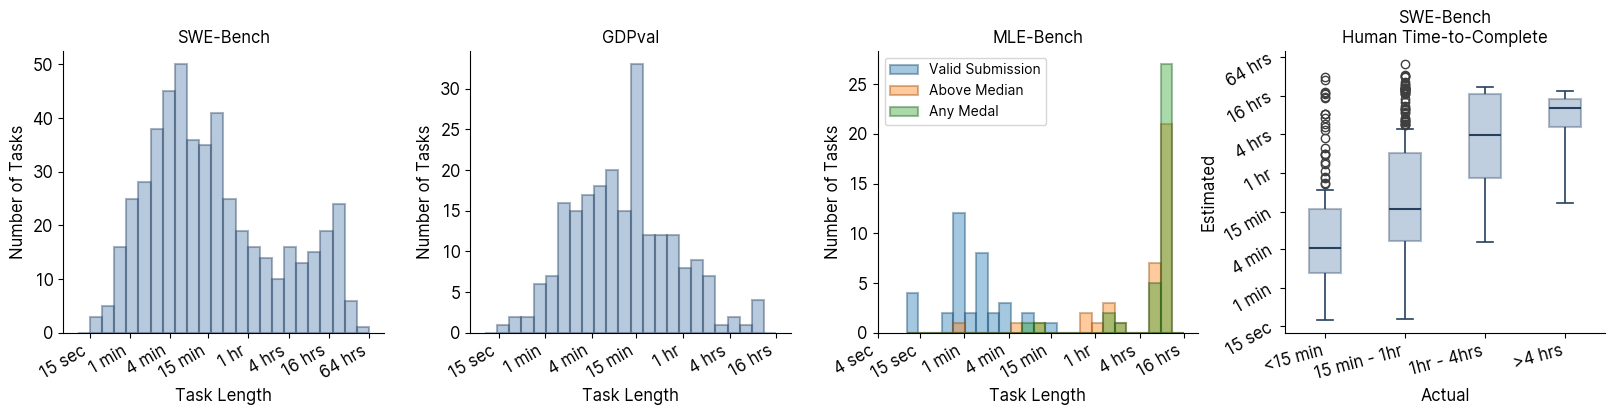

In [26]:
xticks = [
    1/60, 4/60, 15/60, 1, 4, 15, 60, 4*60, 16*60, 64*60,
]
xtick_labels = [
    "1 sec", "4 sec", "15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs", "16 hrs", "64 hrs"
]

print("-" * 100)
print("Human Time-to-Complete Estimates from IRT Task Difficulty")
print("-" * 100)


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
axes = axes.flatten()

# -----------------------------------------------
# subplot 1: SWE human_minutes histogram (1, 1)
# -----------------------------------------------
ax = axes[0]

minutes = swebench_predictions["predicted_minutes"].to_numpy()
minutes = minutes[np.isfinite(minutes) & (minutes > 0)]

bins = np.geomspace(10/60, 64*60, 25)
ax.hist(minutes, bins=bins, color="#4c78a8", alpha=0.4, edgecolor="#26415f", linewidth=1.5)

ax.set_xscale('log')
ax.set_xticks(xticks[2:])
ax.set_xticklabels(xtick_labels[2:], ha="right", rotation=30)

ax.set_xlabel("Task Length")
ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("SWE-Bench", fontsize=12)



# -----------------------------------------------
# subplot 2: GDPval human_minutes histogram (1, 2)
# -----------------------------------------------
ax = axes[1]

minutes = gdpval_predictions["predicted_minutes"].to_numpy()
minutes = minutes[np.isfinite(minutes) & (minutes > 0)]

bins = np.geomspace(10/60, 16*60, 25)
ax.hist(minutes, bins=bins, color="#4c78a8", alpha=0.4, edgecolor="#26415f", linewidth=1.5)

ax.set_xscale('log')
ax.set_xticks(xticks[2:-1])
ax.set_xticklabels(xtick_labels[2:-1], ha="right", rotation=30)

ax.set_xlabel("Task Length")
ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("GDPval", fontsize=12)


# -----------------------------------------------
# subplot 3: MLE bench human_minutes histogram (1, 3)
# -----------------------------------------------
ax = axes[2]

mle_metric_specs = [
    ('valid_submission', '#1f77b4'),
    ('above_median', '#ff7f0e'),
    ('any_medal', '#2ca02c'),
]

for spec_name, color in mle_metric_specs:
    mlebench_predictions_subset = mlebench_predictions[mlebench_predictions['metric'] == spec_name]
    minutes = mlebench_predictions_subset["predicted_minutes"]
    minutes = minutes[np.isfinite(minutes) & (minutes > 0)].to_numpy()

    bins = np.geomspace(10/60, 16*60, 25)
    ax.hist(
        minutes, bins=bins, color=color, alpha=0.4, 
        edgecolor=darken(color, 0.6), linewidth=1.5, label=spec_name.replace('_', ' ').title()
    )

ax.set_xscale('log')
ax.set_xticks(xticks[1:-1])
ax.set_xticklabels(xtick_labels[1:-1], ha="right", rotation=30)

ax.set_xlabel("Task Length")
ax.set_ylabel("Number of Tasks")
ax.minorticks_off()

ax.set_title("MLE-Bench", fontsize=12)
ax.legend(loc="best", frameon=True, fancybox=True, fontsize=10)


# -----------------------------------------------
# subplot 4: SWE predicted_minutes box distribution (1, 4)
# -----------------------------------------------
ax = axes[3]
bins = [0, 15, 60, 240, np.inf]
labels = ['<15 min', '15 min - 1hr', '1hr - 4hrs', '>4 hrs']

# keep interval information
intervals = pd.cut(
    swebench_predictions['human_minutes'],
    bins=bins,
    include_lowest=True
)

# readable bucket label
swebench_predictions['time_bucket'] = intervals.map(lambda iv: labels[bins.index(iv.right) - 1])

# boxplot between time buckets [x] and predicted minutes [y]
sns.boxplot(
    data=swebench_predictions,
    x='time_bucket',
    y='predicted_minutes',
    ax=ax,
    width=0.4,
    boxprops=dict(
        facecolor="#4c78a8",
        alpha=0.35,
        edgecolor="#26415f",
        linewidth=1.5,
    ),
    whiskerprops=dict(color="#26415f", linewidth=1.2),
    capprops=dict(color="#26415f", linewidth=1.2),
    medianprops=dict(color="#26415f", linewidth=1.5),
)

ax.set_yscale('log')
ax.set_yticks(xticks[2:])
ax.set_yticklabels(xtick_labels[2:], ha="right", rotation=30)

ax.set_xlabel("Actual")
ax.set_ylabel("Estimated")
ax.set_xticklabels(labels, ha="right", rotation=15)
ax.minorticks_off()

ax.set_title("SWE-Bench\nHuman Time-to-Complete", fontsize=12)


fig.tight_layout(pad=0.15)
fig.savefig(BASE_DIR / "plots" / "task_length_estimation.pdf", dpi=300)
plt.show()

### Success Probability vs Task Difficulty / Length


In [30]:
abilities_df = pd.read_csv(abilities_path)
model_df = abilities_df.copy()
model_df['release_time'] = pd.to_datetime(model_df['release_time'], errors='coerce')
model_df = model_df.dropna(subset=['release_time'])
model_df = model_df.rename(columns={'subject_id': 'model_name'})

bucket_span_months = 5
release_month_numbers = (model_df['release_time'].dt.year * 12 + (model_df['release_time'].dt.month - 1)).astype(int)
anchor_month_number = release_month_numbers.min()

# Assume buckets start from the anchor month number
bucket_indices = ((release_month_numbers - anchor_month_number) // bucket_span_months).astype(int)
bucket_month_numbers = anchor_month_number + bucket_indices * bucket_span_months

bucket_years = bucket_month_numbers // 12
bucket_month_in_year = (bucket_month_numbers % 12) + 1
model_df['bucket_start'] = pd.to_datetime({'year': bucket_years, 'month': bucket_month_in_year, 'day': 1})

bucketed_models_df = model_df.sort_values('ability', ascending=False).groupby('bucket_start', as_index=False).first().sort_values('bucket_start')
display(bucketed_models_df.head(5))

,bucket_start,model_name,ability,release_time
0,2019-02-01,gpt2,-5.521043,2019-02-14
1,2022-01-01,gpt-3.5-turbo-instruct,-3.356530,2022-03-15
2,2022-11-01,gpt-4-0314,-1.613085,2023-03-14
3,2023-09-01,gpt-4-1106,-1.982036,2023-11-06
4,2024-02-01,claude-3-5-sonnet-20240620,-0.488094,2024-06-20


In [31]:
def success_prob(ability, a, b):
    """Calcualate success probability using 2PL IRT model."""
    exp_term = np.exp(-a * (ability - b))
    prob = 1 / (1 + exp_term)
    return prob


model_to_success_prob = []
for i, row in bucketed_models_df.iterrows():
    ability = row['ability']
    model_name = row['model_name']
    release_time = row['release_time']
    bucket_start = row['bucket_start']
    
    task_sources = [
        ("swebench", swebench_predictions),
        ("mlebench", mlebench_predictions),
        ("gdpval", gdpval_predictions),
    ]
    
    # calculate success probability for each task in each source
    for task_source_name, task_source_df in task_sources:
        for j, task_row in task_source_df.iterrows():
            task_id = task_row['task_id']
            a = task_row['a']
            b = task_row['b']
            predicted_time = task_row['predicted_minutes']
            prob = success_prob(ability, a, b)
            model_to_success_prob.append({
                "model_name": model_name, 
                "release_time": release_time, 
                "bucket_start": bucket_start, 
                "task_id": task_id, 
                "task_source": task_source_name,
                "success_prob": prob,
                "predicted_minutes": predicted_time,
                "difficulty_b": b,
            })

model_to_success_prob_df = pd.DataFrame(model_to_success_prob)
model_to_success_prob_df.head(5)

,model_name,release_time,bucket_start,task_id,task_source,success_prob,predicted_minutes,difficulty_b
0,gpt2,2019-02-14,2019-02-01,astropy__astropy-12907,swebench,5.477374e-05,7.803723,-0.751985
1,gpt2,2019-02-14,2019-02-01,astropy__astropy-13033,swebench,1.800280e-05,1354.869296,5.261611
2,gpt2,2019-02-14,2019-02-01,astropy__astropy-13236,swebench,3.162856e-03,841.171697,4.705755
3,gpt2,2019-02-14,2019-02-01,astropy__astropy-13398,swebench,4.847221e-09,1256.817610,5.174008
4,gpt2,2019-02-14,2019-02-01,astropy__astropy-13453,swebench,7.260400e-05,15.533822,0.050804


In [ ]:
def truncate_cmap(cmap, minval=0.25, maxval=1.0, n=256):
    """Cut off the very lightest colors so the bottom is more visible."""
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap


def plot_success_prob_over_time(df, threshold=0.5, column_name="difficulty_b"):
    fig, ax = plt.subplots(figsize=(8, 6))

    bucket_starts = df['bucket_start'].sort_values().unique()
    n_buckets = len(bucket_starts)

    # --- continuous colormap, slightly truncated at the bottom ---
    base_cmap = plt.get_cmap('YlGn')
    cmap = truncate_cmap(base_cmap, 0.35, 1.0)  # bottom now darker but still ordered
    
    window = 15  # number of points in the smoothing window
    
    # draw horizontal line at success prob = 0.5
    ax.axhline(threshold, color="#7f7f7f", linestyle="--", linewidth=1.2, alpha=0.8)

    value_at_threshold = [] # to store the column value where success_prob crosses the threshold

    for i, bucket_start in enumerate(bucket_starts):
        subset = model_to_success_prob_df[
            model_to_success_prob_df['bucket_start'] == bucket_start
        ].sort_values(column_name)

        # rolling mean/std to smooth
        mean = subset['success_prob'].rolling(window=window, center=True, min_periods=3).mean()
        std = subset['success_prob'].rolling(window=window, center=True, min_periods=3).std().fillna(0)

        x = subset[column_name].to_numpy()
        y = mean.to_numpy()
        y_lower = y - std.to_numpy()
        y_upper = y + std.to_numpy()

        # sample along the *continuous* colormap
        color = cmap(i / (n_buckets - 1)) if n_buckets > 1 else cmap(0.5)

        # smoothed line
        ax.plot(
            x, y,
            color=color,
            label=bucket_start.strftime('%Y-%m'),
            linewidth=1.5,
        )

        # shaded error band
        ax.fill_between(
            x, y_lower, y_upper,
            color=color,
            alpha=0.15,
            linewidth=0,
        )
        
        # ---- find difficulty b where success_prob ~ 0.5 ----
        mask = ~np.isnan(y)
        x_valid = x[mask]
        y_valid = y[mask]

        if len(x_valid) == 0:
            continue
        
        # if max success prob is below threshold, skip this bucket
        if y_valid.max() < threshold:
            continue

        # index where |y - 0.5| is minimal
        idx = np.argmin(np.abs(y_valid - threshold))
        value_star = x_valid[idx]
        value_at_threshold.append((bucket_start, value_star))

        # mark this point on the plot
        ax.scatter(
            value_star, threshold,
            color=color,
            edgecolor="black",
            s=40,
            zorder=5,
        )

        ax.axvline(
            value_star, 
            ymin=0, ymax=threshold,
            color=color,
            linestyle="--", 
            linewidth=2,
            alpha=0.6,
        )
     
    ax.set_ylabel("Success Probability")
    
    if column_name != "difficulty_b":
        ax.set_xscale('log')
        xticks = [
            4/60, 15/60, 1, 4, 15, 60, 4*60, 16*60, 64*60,
        ]
        xtick_labels = [
            "4 sec", "15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs", "16 hrs", "64 hrs"
        ]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels, ha="right", rotation=30)

    
    if column_name == "difficulty_b":
        ax.set_xlabel("Task Difficulty")
        # ax.set_title("Newer models are succeeding at more difficult tasks", fontsize=12)
    else:
        ax.set_xlabel("Task Length")
        # ax.set_title("Newer models are succeeding at more longer tasks", fontsize=12)

    # ---- continuous colorbar ----
    norm = plt.Normalize(vmin=-0.5, vmax=n_buckets - 0.5)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label("Release Date")

    ticks = np.arange(n_buckets)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([b.strftime('%Y-%m') for b in bucket_starts])

    ax.grid(True, which="major", linestyle="--", alpha=0.6)
    ax.minorticks_off()
    
    if column_name == "difficulty_b":
        title_suffix = "task_difficulty"
    else:
        title_suffix = "task_length"

    plt.tight_layout()
    fig.savefig(BASE_DIR / "plots" / f"model_success_prob_vs_{title_suffix}_threshold_{threshold:.2f}.pdf", dpi=300)
    plt.show()


----------------------------------------------------------------------------------------------------
Success Probability vs Task Difficulty over Model Release Time at 50% success rate
----------------------------------------------------------------------------------------------------


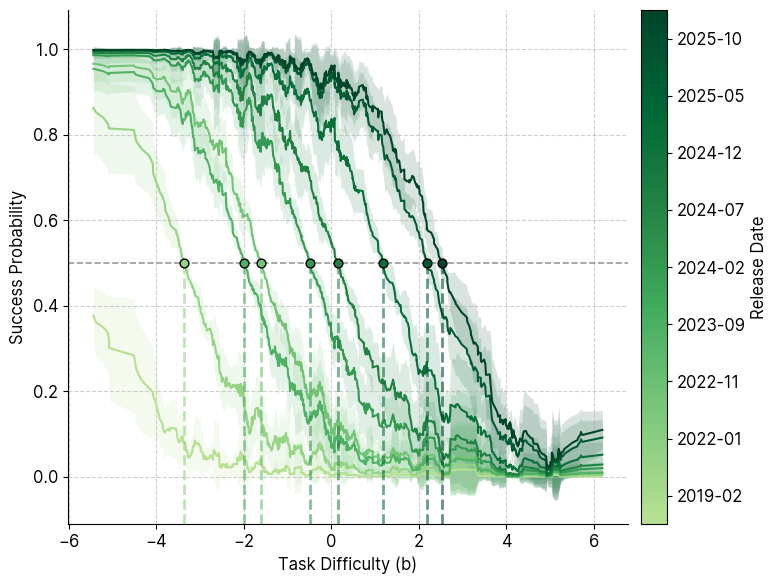

In [41]:
print("-" * 100)
print("Success Probability vs Task Difficulty over Model Release Time at 50% success rate")
print("-" * 100)

plot_success_prob_over_time(model_to_success_prob_df, threshold=0.5, column_name="difficulty_b")

----------------------------------------------------------------------------------------------------
Success Probability vs Task Length over Model Release Time at 50% success rate
----------------------------------------------------------------------------------------------------


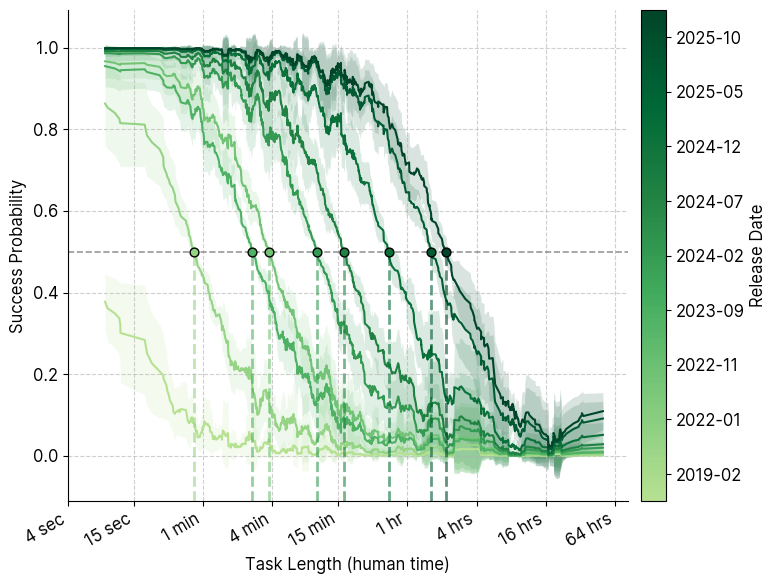

In [42]:
print("-" * 100)
print("Success Probability vs Task Length over Model Release Time at 50% success rate")
print("-" * 100)

plot_success_prob_over_time(model_to_success_prob_df, threshold=0.5, column_name="predicted_minutes")

----------------------------------------------------------------------------------------------------
Success Probability vs Task Difficulty over Model Release Time at 80% success rate
----------------------------------------------------------------------------------------------------


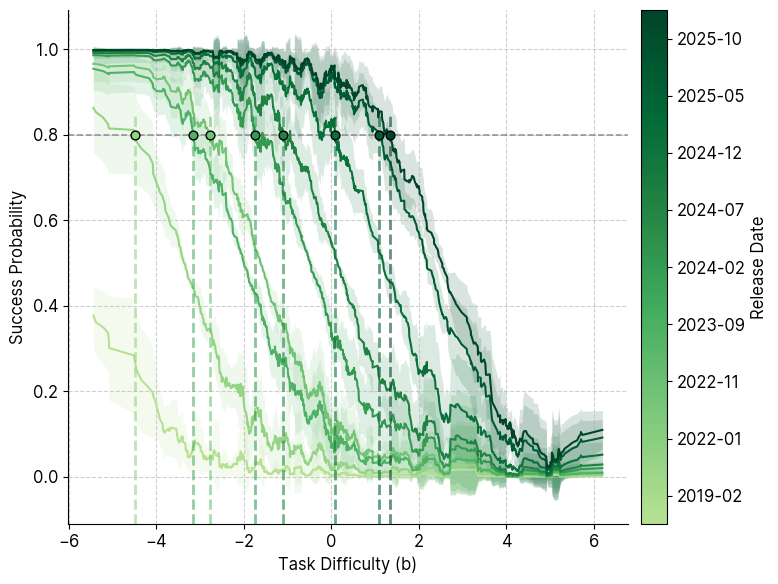

In [43]:
print("-" * 100)
print("Success Probability vs Task Difficulty over Model Release Time at 80% success rate")
print("-" * 100)

plot_success_prob_over_time(model_to_success_prob_df, threshold=0.8, column_name="difficulty_b")

----------------------------------------------------------------------------------------------------
Success Probability vs Task Length over Model Release Time at 80% success rate
----------------------------------------------------------------------------------------------------


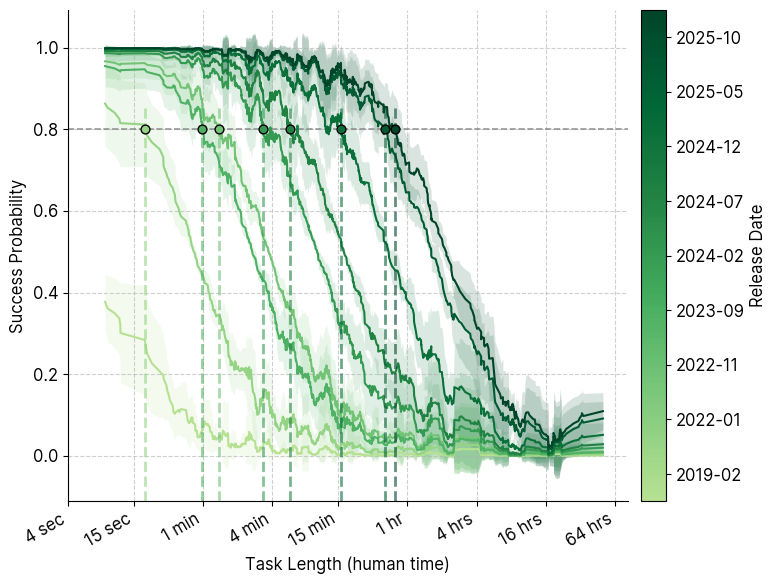

In [44]:
print("-" * 100)
print("Success Probability vs Task Length over Model Release Time at 80% success rate")
print("-" * 100)

plot_success_prob_over_time(model_to_success_prob_df, threshold=0.8, column_name="predicted_minutes")

### Human Time Estimate Trend Forecasting


In [45]:
model_maps = {
    "gpt-3.5-turbo-instruct": "GPT-3.5",
    "gpt-4-0314": "GPT-4",
    "gpt-4o-2024-05-13": "GPT-4o",
    "claude-3-5-sonnet-20240620": "Claude 3.5 Sonnet",
    "claude-3-7-sonnet-20250219": "Claude 3.7 Sonnet",
    "o1": "o1",
    "o3": "o3",
    "claude-4-sonnet-20250514": "Claude 4 Sonnet",
    "claude-4.5-opus-medium": "Claude 4.5 Opus",
    "gemini-3-pro-preview": "Gemini 3 Pro",
    "gpt-5-2025-08-07": "GPT-5"
}

In [46]:
all_models_to_success_prob = []
for i, row in model_df.iterrows():
    ability = row['ability']
    model_name = row['model_name']
    release_time = row['release_time']
    bucket_start = row['bucket_start']
    
    task_sources = [
        ("swebench", swebench_predictions),
        ("mlebench", mlebench_predictions),
        ("gdpval", gdpval_predictions),
    ]
    
    # calculate success probability for each task in each source
    for task_source_name, task_source_df in task_sources:
        for j, task_row in task_source_df.iterrows():
            task_id = task_row['task_id']
            a = task_row['a']
            b = task_row['b']
            predicted_time = task_row['predicted_minutes']
            prob = success_prob(ability, a, b)
            all_models_to_success_prob.append({
                "model_name": model_name, 
                "release_time": release_time, 
                "bucket_start": bucket_start, 
                "task_id": task_id, 
                "task_source": task_source_name,
                "success_prob": prob,
                "predicted_minutes": predicted_time,
                "difficulty_b": b,
            })

all_models_to_success_prob_df = pd.DataFrame(all_models_to_success_prob)
all_models_to_success_prob_df.head(5)

,model_name,release_time,bucket_start,task_id,task_source,success_prob,predicted_minutes,difficulty_b
0,claude-3-5-sonnet-20240620,2024-06-20,2024-02-01,astropy__astropy-12907,swebench,0.632499,7.803723,-0.751985
1,claude-3-5-sonnet-20240620,2024-06-20,2024-02-01,astropy__astropy-13033,swebench,0.002942,1354.869296,5.261611
2,claude-3-5-sonnet-20240620,2024-06-20,2024-02-01,astropy__astropy-13236,swebench,0.051086,841.171697,4.705755
3,claude-3-5-sonnet-20240620,2024-06-20,2024-02-01,astropy__astropy-13398,swebench,0.000040,1256.817610,5.174008
4,claude-3-5-sonnet-20240620,2024-06-20,2024-02-01,astropy__astropy-13453,swebench,0.284599,15.533822,0.050804


In [99]:
def plot_task_length_forecasts(df, threshold=0.5, model_maps=model_maps):
    model_names = df["model_name"].unique().tolist()
    
    release_times = []
    mean_estimates = []
    std_estimates = []
    model_labels = []
    
    window = 15  # number of points in the smoothing window
    column_name = "difficulty_b"

    for model_name in model_names:
        subset = df[df['model_name'] == model_name].sort_values('predicted_minutes')

        # rolling mean/std to smooth
        mean = subset['success_prob'].rolling(window=window, center=True, min_periods=3).mean()
        std = subset['success_prob'].rolling(window=window, center=True, min_periods=3).std().fillna(0)

        x = subset[column_name].to_numpy()
        y = mean.to_numpy()

        # ---- find difficulty or predicted_minutes where success_prob ~ threshold ----
        mask = ~np.isnan(y)
        x_valid = x[mask]
        y_valid = y[mask]
        
        if len(x_valid) == 0:
            continue
        
        # if max success prob is below threshold, skip this bucket
        if y_valid.max() < threshold:
            continue

        # index where |y - 0.5| is minimal
        idx = np.argmin(np.abs(y_valid - threshold))
        value_star = x_valid[idx]
        
        # calculate std dev of b where success prob is within 1 std dev of threshold
        within_std_mask = (y_valid >= (threshold - std.to_numpy()[mask][idx])) & (y_valid <= (threshold + std.to_numpy()[mask][idx]))
        value_std = x_valid[within_std_mask].std()

        release_time = subset['release_time'].iloc[0]

        # store results for regression plot
        release_times.append(release_time)
        mean_estimates.append(value_star)
        std_estimates.append(value_std)
        model_labels.append(model_name)


    fit_df = pd.DataFrame({
        "model_name": model_labels,
        "release_time": pd.to_datetime(release_times),
        "difficulty_b": mean_estimates,
        "difficulty_b_std": std_estimates,
    })
    fit_df["release_months_norm"] = fit_df["release_time"].dt.year * 12 + (fit_df["release_time"].dt.month - 1).astype(float)

    predicted_minutes = []
    predicted_minutes_std = []
    for i, row in fit_df.iterrows():
        b, b_std = row['difficulty_b'], row['difficulty_b_std']
        pred_min = predict_minutes_from_b(b)
        pred_min_std = predict_minutes_from_b(b + b_std) - predict_minutes_from_b(b - b_std)
        predicted_minutes.append(pred_min)
        predicted_minutes_std.append(pred_min_std)
        
    fit_df['predicted_minutes'] = predicted_minutes
    fit_df['predicted_minutes_std'] = predicted_minutes_std

    # select the frontier models for paretto curve
    fit_sorted = fit_df.sort_values("release_time")

    frontier_rows = []
    best_so_far = -np.inf
    min_improvement = 0.2   # only count if difficulty improves by at least 0.2

    for _, row in fit_sorted.iterrows():
        b = row["difficulty_b"]
        if b > best_so_far + min_improvement:
            frontier_rows.append(row)
            best_so_far = b

    frontier_df = pd.DataFrame(frontier_rows).reset_index(drop=True)
    
    
    # x: release time in months, y: frontier difficulty
    x = frontier_df["release_months_norm"].to_numpy().astype(int)
    y = frontier_df['difficulty_b'].to_numpy().astype(float)
    yerr = frontier_df['difficulty_b_std'].to_numpy().astype(float)

    # drop NaNs if any
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    yerr = yerr[mask]

    # linear regression: difficulty_b = slope * t_months + intercept
    reg_ = stats.linregress(x, y)

    # smooth line over the x-range
    x_fit = np.linspace(2021 * 12 + 9, 2026 * 12 + 4, 200)
    y_fit = reg_.intercept + reg_.slope * x_fit


    # estimate doubling time based on slope
    slope = reg_.slope  # units: difficulty_b per month

    # how much delta-b corresponds to 2x human time
    delta_b_for_double = np.log(2.0) / np.log(2.36)  # ≈ 0.81

    # doubling time of human time (in months)
    doubling_time_months = delta_b_for_double / slope

    print("-" * 100)
    print("slope (b per month):", slope)
    print("Δb for 2x human time:", delta_b_for_double)
    print("Doubling time: {:.2f} months".format(doubling_time_months))
    print("-" * 100)

    # ----------------------------------------------------------------------------------
    # ----------------------------------------------------------------------------------
    # Model release date vs task difficulty plot (linear fit)
    # ----------------------------------------------------------------------------------
    # ----------------------------------------------------------------------------------

    fig, ax = plt.subplots(figsize=(10, 6))

    # smoothed line
    ax.scatter(
        fit_df["release_months_norm"],
        fit_df["difficulty_b"],
        color="#1f77b4",
        s=30,
    )

    # shaded error band
    ax.errorbar(
        fit_df["release_months_norm"],
        fit_df["difficulty_b"],
        yerr=fit_df["difficulty_b_std"],
        fmt='o',
        color="#1f77b4",
        markersize=4,
        capsize=3,
        alpha=0.9,
    )

    ax.plot(x_fit, y_fit, color='#1f77b4', linestyle="--", linewidth=2)

    # plot error bar around the fit line based on std dev of yerr
    y_fit_upper = y_fit + np.mean(yerr)
    y_fit_lower = y_fit - np.mean(yerr)
    ax.fill_between(
        x_fit, y_fit_lower, y_fit_upper,
        color='#1f77b4',
        alpha=0.2,
        linewidth=0,
    )

    for model_name, model_label in model_maps.items():
        # position label slightly above the point (use + yerr if you want it above the bar)
        row = fit_df[fit_df["model_name"] == model_name].iloc[0]
        y_for_label = row["difficulty_b"]
        if not np.isnan(row["difficulty_b_std"]):
            y_for_label += row["difficulty_b_std"] + 0.03  # small vertical gap

        ax.annotate(
            model_label,                     # text
            xy=(row["release_months_norm"], y_for_label),# point to label
            xytext=(0, 2),                         # offset in points
            textcoords="offset points",
            fontsize=8,
            ha="center",
            va="bottom",
            rotation=45,                           # rotate to reduce overlap
            # add box around text for readability with dashed border
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='white', linestyle='--')
        )


    xticks = [
        2022 * 12 + 0, 2022 * 12 + 6, 2023 * 12 + 0, 2023 * 12 + 6,
        2024 * 12 + 0, 2024 * 12 + 6, 2025 * 12 + 0, 2025 * 12 + 6,
        2026 * 12 + 0
    ]
    xtick_labels = [
        "2022-01", "2022-07", "2023-01", "2023-07", "2024-01", "2024-07", "2025-01", "2025-07", "2026-01"
    ]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, ha="right", rotation=30)

    ax.set_xlabel("Model Release Date")
    ax.set_ylabel("Task Difficulty")

    ax.grid(True, which="major", linestyle="--", alpha=0.6)
    ax.minorticks_off()

    ax.text(
        0.025, 0.98, 
        f"R\u00b2 = {r_squared:.2f}",
        transform=ax.transAxes, 
        ha="left", va="top",
        fontsize=12,
        verticalalignment='top', 
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='white')
    )

    fig.tight_layout()
    fig.savefig(BASE_DIR / "plots" / f"model_release_date_vs_task_difficulty_threshold{threshold:.2f}.pdf", dpi=300)
    plt.show()
    
    
    # ----------------------------------------------------------------------------------
    # ----------------------------------------------------------------------------------
    # Model release date vs log task length plot (linear fit)
    # ----------------------------------------------------------------------------------
    # ----------------------------------------------------------------------------------    
    fig, ax = plt.subplots(figsize=(10, 6))

    # smoothed line
    ax.scatter(
        fit_df["release_months_norm"],
        fit_df["predicted_minutes"],
        color="#1f77b4",
        s=30,
    )

    # shaded error band
    ax.errorbar(
        fit_df["release_months_norm"],
        fit_df["predicted_minutes"],
        yerr=fit_df["predicted_minutes_std"],
        fmt='o',
        color="#1f77b4",
        markersize=4,
        capsize=3,
        alpha=0.9,
    )

    for model_name, model_label in model_maps.items():
        # position label slightly above the point (use + yerr if you want it above the bar)
        row = fit_df[fit_df["model_name"] == model_name].iloc[0]
        y_for_label = row["predicted_minutes"]
        if not np.isnan(row["predicted_minutes_std"]):
            y_for_label += row["predicted_minutes_std"] + 0.03  # small vertical gap

        ax.annotate(
            model_label,                     # text
            xy=(row["release_months_norm"], y_for_label),# point to label
            xytext=(0, 2),                         # offset in points
            textcoords="offset points",
            fontsize=8,
            ha="center",
            va="bottom",
            rotation=45,                           # rotate to reduce overlap
            # add box around text for readability with dashed border
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='white', linestyle='--')
        )

    y_fit_adjusted = np.array([predict_minutes_from_b(y) for y in y_fit], dtype=float)
    ax.plot(x_fit, y_fit_adjusted, color='#1f77b4', linestyle="--", linewidth=2)

    # plot error bar around the fit line based on std dev of yerr
    y_pts = fit_df["predicted_minutes"].to_numpy(dtype=float)
    s_pts = fit_df["predicted_minutes_std"].to_numpy(dtype=float)

    eps = 1e-12
    y_pts = np.clip(y_pts, eps, None)
    s_pts = np.clip(s_pts, 0.0, None)

    sigma_log_pts = s_pts / y_pts                 # >= 0
    sigma_log = float(np.nanmedian(sigma_log_pts))  # robust typical value

    y_fit_lower = y_fit_adjusted * np.exp(-sigma_log)
    y_fit_upper = y_fit_adjusted * np.exp(+sigma_log)

    
    ax.fill_between(
        x_fit, y_fit_lower, y_fit_upper,
        color='#1f77b4', # blue
        alpha=0.2,
        linewidth=0,
    )

    xticks = [
        2022 * 12 + 0, 2022 * 12 + 6, 2023 * 12 + 0, 2023 * 12 + 6,
        2024 * 12 + 0, 2024 * 12 + 6, 2025 * 12 + 0, 2025 * 12 + 6,
        2026 * 12 + 0
    ]
    xtick_labels = [
        "2022-01", "2022-07", "2023-01", "2023-07", "2024-01", "2024-07", "2025-01", "2025-07", "2026-01"
    ]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, ha="right", rotation=30)

    ax.set_yscale('log')
    yticks = [1/60, 4/60, 15/60, 1, 4, 15, 60, 4*60]
    ytick_labels = ["1 sec", "4 sec", "15 sec", "1 min", "4 min", "15 min", "1 hr", "4 hrs"]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels, ha="right")
    ax.set_xlabel("Model Release Date")
    ax.set_ylabel("Task Length")

    ax.grid(True, which="major", linestyle="--", alpha=0.6)
    ax.minorticks_off()
    
    ax.text(
        0.025, 0.98, 
        f"R\u00b2 = {r_squared:.2f}",
        transform=ax.transAxes, 
        ha="left", va="top",
        fontsize=12,
        verticalalignment='top', 
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='white')
    )

    fig.tight_layout()
    fig.savefig(BASE_DIR / "plots" / f"model_release_date_vs_time_estimate_log_scale_threshold{threshold:.2f}.pdf", dpi=300)
    plt.show()


    # ----------------------------------------------------------------------------------
    # ----------------------------------------------------------------------------------
    # Model release date vs task length plot (exponential fit)
    # ----------------------------------------------------------------------------------
    # ----------------------------------------------------------------------------------    

    fig, ax = plt.subplots(figsize=(10, 6))

    # smoothed line
    ax.scatter(
        fit_df["release_months_norm"],
        fit_df["predicted_minutes"],
        color="#1f77b4",
        s=30,
    )

    # shaded error band
    ax.errorbar(
        fit_df["release_months_norm"],
        fit_df["predicted_minutes"],
        yerr=fit_df["predicted_minutes_std"],
        fmt='o',
        color="#1f77b4",
        markersize=4,
        capsize=3,
        alpha=0.9,
    )

    for model_name, model_label in model_maps.items():
        # position label slightly above the point (use + yerr if you want it above the bar)
        row = fit_df[fit_df["model_name"] == model_name].iloc[0]
        y_for_label = row["predicted_minutes"]
        if not np.isnan(row["predicted_minutes_std"]):
            y_for_label += row["predicted_minutes_std"] + 0.03  # small vertical gap

        ax.annotate(
            model_label,                     # text
            xy=(row["release_months_norm"], y_for_label),# point to label
            xytext=(0, 2),                         # offset in points
            textcoords="offset points",
            fontsize=8,
            ha="center",
            va="bottom",
            rotation=45,                           # rotate to reduce overlap
            # add box around text for readability with dashed border
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='white', linestyle='--')
        )

    # -------------------------------------------------------
    #               exponential fit line
    # -------------------------------------------------------

    y_fit_adjusted = np.array([predict_minutes_from_b(y) for y in y_fit], dtype=float)
    ax.plot(x_fit, y_fit_adjusted, color='#1f77b4', linestyle="--", linewidth=2)

    # plot error bar around the fit line based on std dev of yerr
    y_fit_upper = y_fit_adjusted + np.mean(fit_df["predicted_minutes_std"])
    y_fit_lower = y_fit_adjusted - np.mean(fit_df["predicted_minutes_std"])
    ax.fill_between(
        x_fit, y_fit_lower, y_fit_upper,
        color='#1f77b4', # blue
        alpha=0.2,
        linewidth=0,
    )

    xticks = [
        2022 * 12 + 0, 2022 * 12 + 6, 2023 * 12 + 0, 2023 * 12 + 6,
        2024 * 12 + 0, 2024 * 12 + 6, 2025 * 12 + 0, 2025 * 12 + 6,
        2026 * 12 + 0
    ]
    xtick_labels = [
        "2022-01", "2022-07", "2023-01", "2023-07", "2024-01", "2024-07", "2025-01", "2025-07", "2026-01"
    ]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, ha="right", rotation=30)

    yticks = [30, 60, 90, 120, 150, 180, 210]
    ytick_labels = ["30 min", "1 hr", "1h 30 min", "2 hrs", "2 hr 30 min", "3 hrs", "3 hr 30 min"]
    if threshold == 0.8:
        yticks = yticks[:-3]
        ytick_labels = ytick_labels[:-3]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels, ha="right")
    ax.set_xlabel("Model Release Date")
    ax.set_ylabel("Task Length")

    ax.grid(True, which="major", linestyle="--", alpha=0.6)
    ax.minorticks_off()


    fig.tight_layout()
    fig.savefig(BASE_DIR / "plots" / f"model_release_date_vs_time_estimate_threshold{threshold:.2f}.pdf", dpi=300)
    plt.show()


----------------------------------------------------------------------------------------------------
slope (b per month): 0.13458848885979482
Δb for 2x human time: 0.8072413686510176
Doubling time: 6.00 months
----------------------------------------------------------------------------------------------------


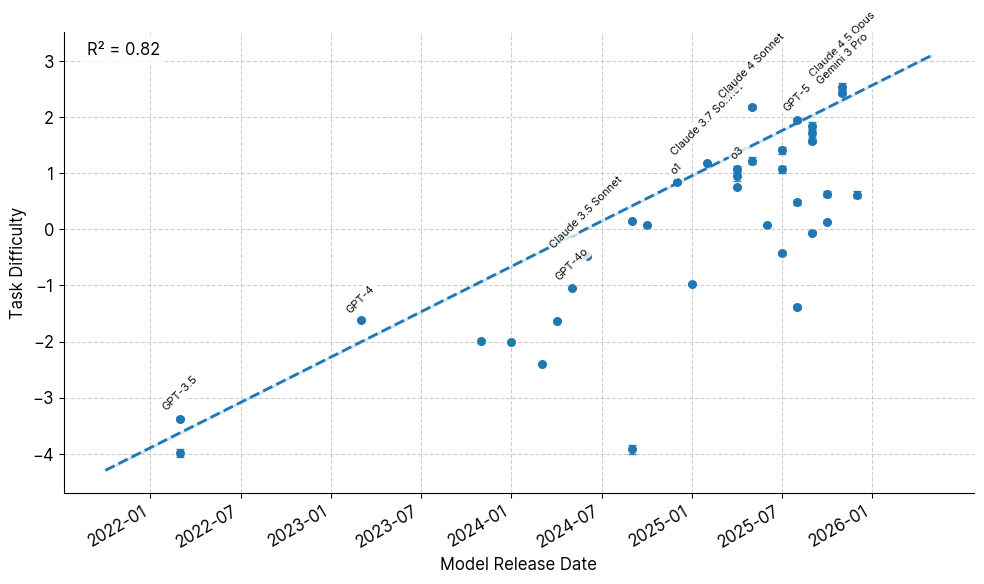

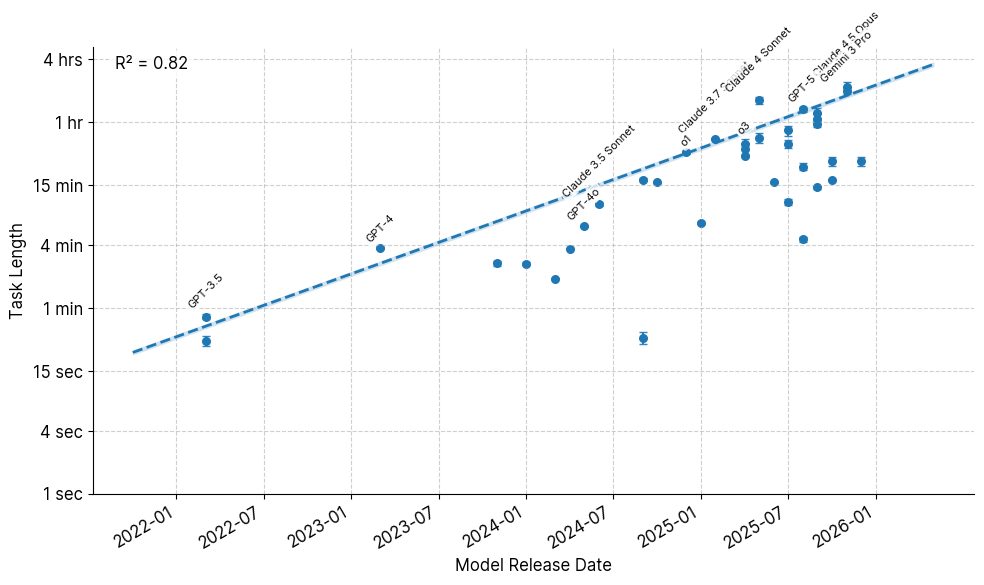

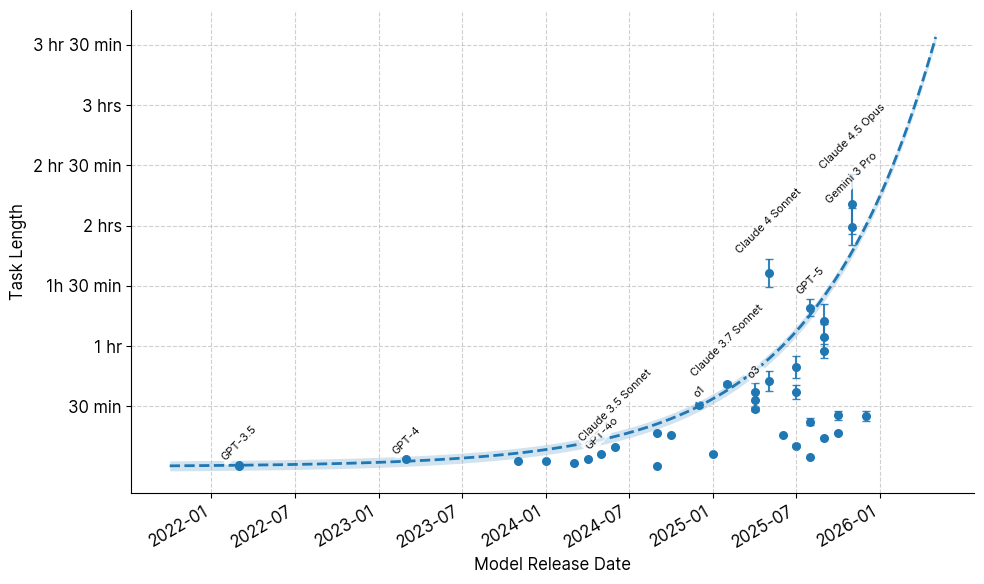

In [102]:
plot_task_length_forecasts(all_models_to_success_prob_df, threshold=0.5, model_maps=model_maps)

----------------------------------------------------------------------------------------------------
slope (b per month): 0.13395168754516404
Δb for 2x human time: 0.8072413686510176
Doubling time: 6.03 months
----------------------------------------------------------------------------------------------------


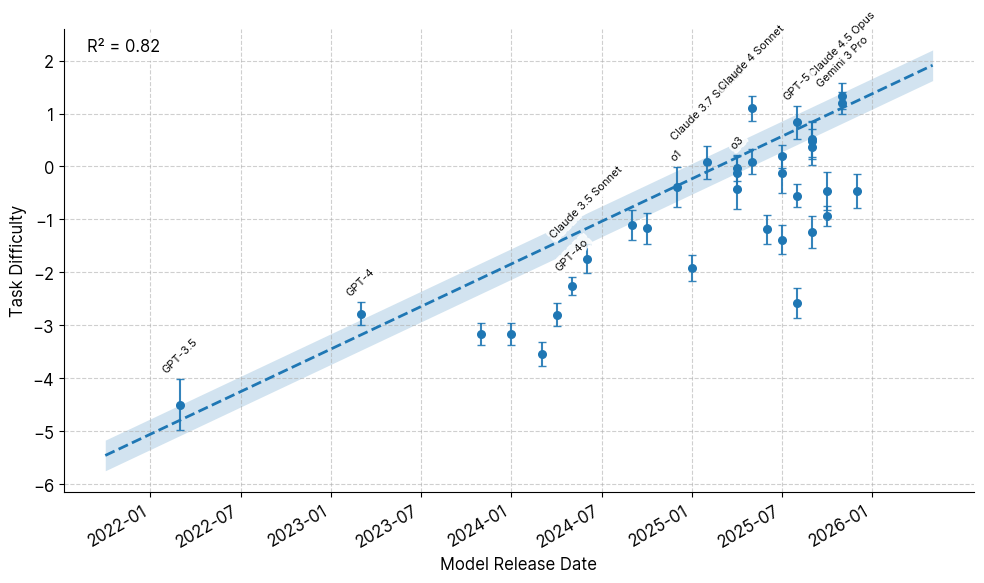

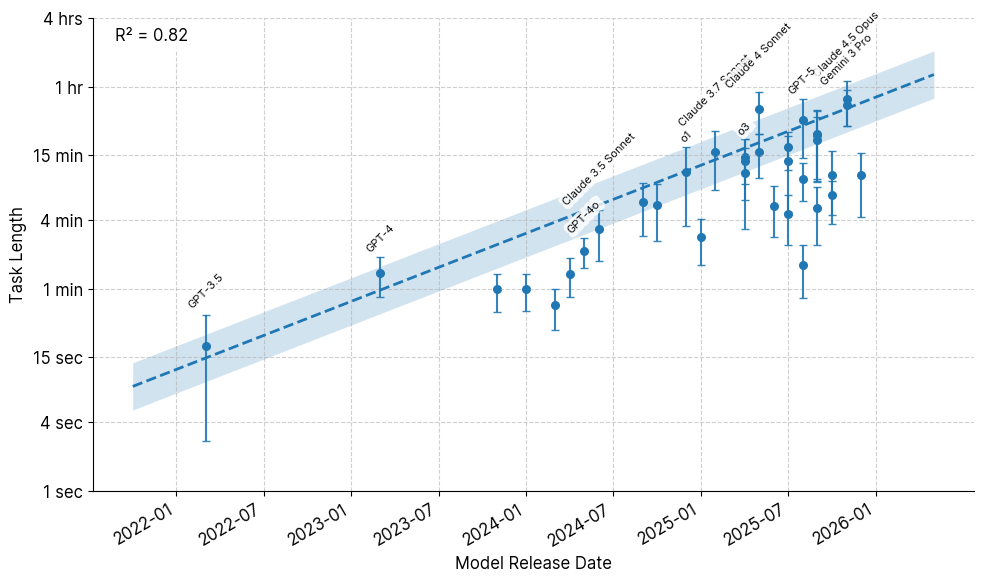

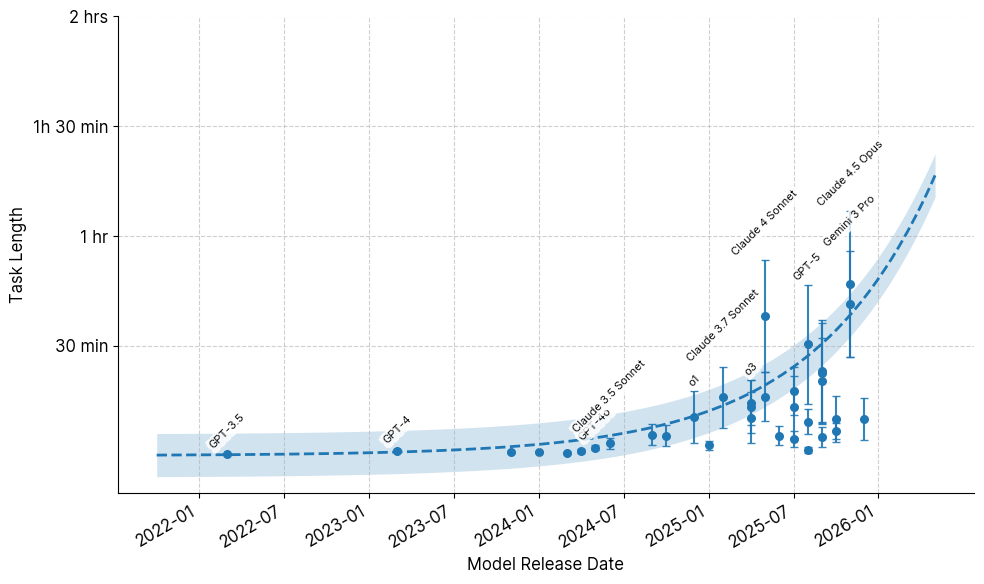

In [103]:
plot_task_length_forecasts(all_models_to_success_prob_df, threshold=0.8, model_maps=model_maps)